In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments

c:\Users\jayor\Documents\repos\transformer_chess\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_dataset = load_dataset("royal42/lichess_elite_games")

Found cached dataset parquet (C:/Users/jayor/.cache/huggingface/datasets/royal42___parquet/royal42--lichess_elite_games-24250dad91f3120d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [3]:
tokenizer = AutoTokenizer.from_pretrained("../data/tokenizations/chess-tokenizer/")

In [6]:
tokenizer.model_max_length

1024

In [33]:
print(raw_dataset['train'][0])

{'text': 'e4 d5 exd5 Qxd5 Nc3 Qa5 d4 c6 Nf3 Nf6 Bc4 Bg4 h3 Bh5 O-O e6 g4 Nxg4 hxg4 Bxg4 Be2 Bd6 Ne4 Bc7 Nc5 Bd6 Nxb7 Qc7 Nxd6+ Qxd6 Qd2 Bf5 c4 h5 Qf4 Qb4 d5 cxd5 cxd5 Qxf4 Bxf4 exd5 Nd4 Bd7 Bf3 Na6 Rfe1+ Kf8 Bxd5 Re8 Bd6+ Kg8 Rxe8+ Bxe8 Re1 Kh7 Re7'}


Figure out longest game to set context length

In [35]:
lengths = []
for row in raw_dataset['train']:
    game = row['text'] # String game
    game_list = game.split(' ')
    lengths.append(len(game_list))

In [40]:
lengths.sort(reverse=True)
print(lengths[0:500])

[601, 601, 597, 574, 571, 541, 541, 507, 500, 492, 479, 479, 474, 473, 470, 467, 464, 460, 455, 441, 440, 430, 429, 426, 423, 415, 415, 412, 409, 407, 406, 406, 402, 398, 398, 396, 390, 389, 389, 386, 384, 383, 381, 380, 379, 378, 377, 377, 376, 373, 373, 371, 371, 368, 367, 367, 367, 366, 365, 363, 362, 362, 361, 360, 358, 357, 357, 352, 352, 352, 351, 350, 350, 349, 348, 347, 347, 347, 345, 344, 344, 343, 343, 343, 342, 342, 341, 339, 339, 338, 338, 338, 338, 338, 336, 336, 336, 334, 334, 334, 333, 333, 333, 332, 330, 329, 329, 328, 326, 326, 326, 325, 325, 324, 323, 323, 323, 323, 322, 321, 321, 321, 320, 320, 320, 320, 318, 317, 316, 316, 316, 316, 315, 315, 314, 314, 314, 314, 313, 312, 312, 312, 311, 311, 311, 310, 310, 310, 310, 310, 309, 309, 309, 308, 308, 308, 308, 308, 308, 307, 307, 307, 306, 306, 306, 305, 305, 305, 305, 304, 304, 304, 304, 303, 303, 303, 303, 303, 303, 302, 301, 301, 300, 300, 299, 299, 299, 298, 298, 298, 297, 297, 297, 297, 296, 296, 296, 296, 296, 296,

Plot

In [41]:
import seaborn as sns

C:\Users\jayor\AppData\Local\Temp\ipykernel_25116\1069541907.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths)


<Axes: ylabel='Density'>

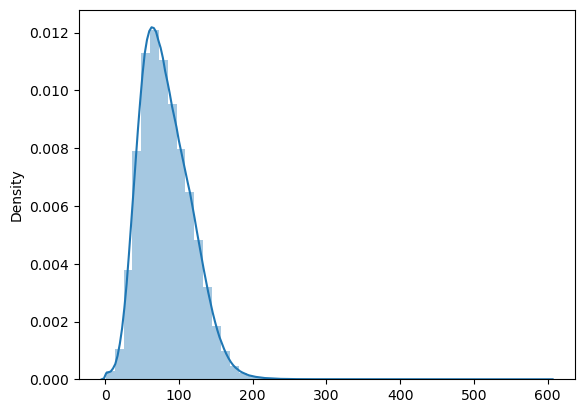

In [42]:
sns.distplot(lengths)

Looks like 256 is a pretty good starting point, we will maintain the bulk of the data. This doesn't work, however, with 6 GB VRAM, so we stick with 128 for now.

In [8]:
context_length = 200

In [8]:
def tokenize(element):
    outputs = tokenizer(
        element["text"],
        max_length=context_length,
        truncation=True
    )

    return outputs


tokenized_datasets = raw_dataset.map(
    tokenize, batched=True, remove_columns=raw_dataset["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/2032806 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2032806
    })
})

In [9]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [10]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


Split dataset

In [11]:
#train_size = 10_000
#test_size = int(0.1 * train_size)
split_dataset = tokenized_datasets["train"].train_test_split(
    test_size=.1, seed=42
)

Setup model

In [9]:
from transformers import GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

In [10]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 86.4M parameters


In [14]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\jayor\.huggingface\token


Set up trainer classes

In [15]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="./test2",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
)

Cloning https://huggingface.co/royal42/test2 into local empty directory.
Using cuda_amp half precision backend


In [18]:
trainer.train(resume_from_checkpoint = True)

Loading model from ./test2\checkpoint-5000.
***** Running training *****
  Num examples = 1829525
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 8
  Total optimization steps = 7146
  Number of trainable parameters = 65128704
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 5000
  Will skip the first 0 epochs then the first 40000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/7146 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 5267.1081, 'train_samples_per_second': 347.349, 'train_steps_per_second': 1.357, 'train_loss': 0.2720278150855811, 'epoch': 1.0}


TrainOutput(global_step=7146, training_loss=0.2720278150855811, metrics={'train_runtime': 5267.1081, 'train_samples_per_second': 347.349, 'train_steps_per_second': 1.357, 'train_loss': 0.2720278150855811, 'epoch': 1.0})

In [19]:
trainer.push_to_hub()

Saving model checkpoint to ./test2
Configuration saved in ./test2\config.json
Model weights saved in ./test2\pytorch_model.bin
tokenizer config file saved in ./test2\tokenizer_config.json
Special tokens file saved in ./test2\special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 1.00/257M [00:00<?, ?B/s]

Upload file runs/Apr14_12-49-14_LAPTOP-D2IE27G6/1681509929.772105/events.out.tfevents.1681509929.LAPTOP-D2IE27…

Upload file runs/Apr14_12-49-14_LAPTOP-D2IE27G6/events.out.tfevents.1681498186.LAPTOP-D2IE27G6.9404.0:   0%|  …

To https://huggingface.co/royal42/test2
   91739aa..5f13b69  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
To https://huggingface.co/royal42/test2
   5f13b69..47d1916  main -> main



'https://huggingface.co/royal42/test2/commit/5f13b69ea95085844bb0bd105321d1914b6cec06'